In [1]:
# standard imports
import sys
import numpy as np
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rot_sym_mesh
from problem.isentropic_navier_stokes import convection, diffusion, skalar_product, curl

# utility functions
from utilities.utilities import *
from utilities.pod import get_POD, get_activations

# Setting Custom Problem

In [82]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class exp_mesh
mesh = rot_sym_mesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Geometric Constants

In [4]:
# DEFINING CONSTANTS
n = mesh.n                  # number of nodes
N = mesh.N                  # number of cells
T = 220                     # number of snapshots
alpha = 1                   # inner product coefficient  # method for derivative computation
gamma = 1.4                 # isentropic coefficient -> material property
max_POD = 40                # maximum number of POD modes
mach = 0.6                  # mach number
sos = 340.29                # isentropic speed of sound
u_free = mach * sos         # freestream velocity
Re = 100                    # Reynolds number of freeflow
dt = 0.0001                 # simulation time step
include_avg = False         # include average flow in POD computation
nondim = False              # apply nondimensionalization to results
subsampling = 6             # subsampling for data
stabilization = "viscosity" # stabilization method for galerkin system
controlled = False          # activate controlled system
tau = 0                     # penalty term coefficient

# Data Preparation

In [5]:
# reading file data
data_dir  = "./flow_data/lam_cyl_comp_air/mach 0.6/"
data_dict = read_csv_data(data_dir,delay=0,subsampling=subsampling,max_size=T)

# geometric information
x = data_dict["x"][:,0] - 0.5
y = data_dict["y"][:,0]

# fluid velocity and mach number
u = np.divide(data_dict['Momentum_x'], data_dict['Density'])
v = np.divide(data_dict['Momentum_y'], data_dict['Density'])
a = data_dict['Mach']

# construct state based data
q = np.vstack([u,v,a])
T = q.shape[1]
q_avg = np.mean(q,1)
q_fluc = q - np.repeat(np.expand_dims(q_avg,1),T,axis=1)

# data for pod decomposition
if include_avg:
    pod_data = q
else:
    pod_data = q_fluc

### set scalar weights for multiplicative computation
# volume participations
volume_weight = mesh.volume_weights
# additional weight for speed of sound
mach_weight = (2 * alpha / (gamma - 1))
# construction of weights
inner_weight = np.concatenate([np.ones(n),np.ones(n),mach_weight*np.ones(n)]) * volume_weight

100%|██████████| 220/220 [01:09<00:00,  3.17it/s]


# POD Decomposition

In [6]:
[pod_modes, S] = get_POD(pod_data,inner_weight,20)
coeffs = get_activations(pod_data,pod_modes,inner_weight,20)
if nondim:
    coeffs /= u_free

In [7]:
# energy reconstruction threshold
epsilon = 0.99
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))
if num % 2 == 1:
    num+=1

# manual value
num = 6

Number of eigenvectors necessary for thresholded reconstruction: 	4


In [8]:
# plot_activations(coeffs,num,dt=dt*subsampling)

# Control Data Input

In [30]:
control_dir  = "./flow_data/lam_cyl_comp_air/potVortex_0.6_1/"
control_dict = read_csv_data(control_dir,0,1,1)

u_con = np.divide(control_dict['Momentum_x'], control_dict['Density'])
v_con = np.divide(control_dict['Momentum_y'], control_dict['Density'])
a_con = control_dict['Mach']

# construct state based data
q_con = np.vstack([u_con,v_con,a_con]).squeeze()

100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


# Control Function Method
Additional coefficients in Galerkin system

In [31]:
# Computation of Galerkin control terms
Lcon = diffusion(mesh,q_con)
Qcon = convection(mesh,q_con,q_con)
Qconavg_1 = convection(mesh,q_con,q_avg)
Qconavg_2 = convection(mesh,q_avg,q_con)

# initialize arrays
d1 = np.empty(num)
d2 = np.empty(num)
f = np.empty(num)
g = np.empty((num,num))
h = np.empty(num)

# compute temporary L and Q operators for projection
tmp_1 = np.empty((num,3*n))
tmp_2 = np.empty((num,3*n))
for i in tqdm(range(num)):
    tmp_1[i] = convection(mesh,q_con,pod_modes[:,i])
    tmp_2[i] = convection(mesh,pod_modes[:,i],q_con)

# compute finale coefficients
for k in range(num):
    d1[k] = skalar_product(Lcon,pod_modes[:,k],inner_weight)
    d2[k] = skalar_product(Qconavg_1 + Qconavg_2,pod_modes[:,k],inner_weight)
    f[k] = skalar_product(Qcon,pod_modes[:,k],inner_weight)
    h[k] = skalar_product(q_con,pod_modes[:,k],inner_weight)
    for i in range(num):
        g[k,i] = skalar_product(tmp_1[i] + tmp_2[i],pod_modes[:,k],inner_weight)

100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


# Galerkin Coefficients

In [32]:
# Galerkin system coefficients
# Computation of Galerkin system parameters
Qavg = convection(mesh,q_avg,q_avg)
Lavg = diffusion(mesh,q_avg)

# initialize arrays for parameters
b1 = np.empty(num)
b2 = np.empty(num)
L1 = np.empty((num,num))
L2 = np.empty((num,num))
Q_ = [np.empty((num,num,)) for x in range(num)]

# compute L and Q operators for projection
Q_tmp1 = np.empty((num,3*n))
Q_tmp2 = np.empty((num,3*n))
Q_tmp3 = np.empty((num,num,3*n))
L_tmp = np.empty((num,3*n))

for i in tqdm(range(num)):
    Q_tmp1[i] = convection(mesh,q_avg,pod_modes[:,i])
    Q_tmp2[i] = convection(mesh,pod_modes[:,i],q_avg)
    L_tmp[i] = diffusion(mesh,pod_modes[:,i])
    for j in range(num):
        Q_tmp3[i,j] = convection(mesh,pod_modes[:,i],pod_modes[:,j])

# compute ODE coefficients
for k in tqdm(range(num)):
    b1[k] = skalar_product(Lavg,pod_modes[:,k],inner_weight)
    b2[k] = skalar_product(Qavg,pod_modes[:,k],inner_weight)
    for i in range(num):
        L1[k,i] = skalar_product(L_tmp[i],pod_modes[:,k],inner_weight)
        L2[k,i] = skalar_product(np.add(Q_tmp1[i],Q_tmp2[i]),pod_modes[:,k],inner_weight)
        for j in range(num):
            Q_[k][i,j] = skalar_product(Q_tmp3[i,j],pod_modes[:,k],inner_weight)

100%|██████████| 6/6 [00:00<00:00, 108.11it/s]


# Galerkin System

In [33]:
# initial conditions
a0 = coeffs[:num,0]
nu = 1.716e-5

# temporal problem setup
if mach == 0.6:
    dt_ref = 0.0001 * subsampling
    dt = 0.0005
    shed_period = 0.0327

elif mach == 0.1:
    dt_ref = 0.001 * subsampling
    dt = 0.001
    shed_period = 0.18

elif mach == 0.01:
    dt_ref = 0.02 * subsampling
    dt = 0.02
    shed_period = 1.84


# temporal span for solver
t0 = 0
tmax = shed_period * 10
sampling_span = np.linspace(t0,tmax-dt,num=int(tmax/dt))

# dynamic viscosity for stabilization
if stabilization=="viscosity":
    if mach == 0.6:
        # tuned
        if num == 10:
            nu = 4.09   # 10 modes
        elif num == 8:
            nu = 3.24   # 8 modes
        elif num == 6:
            nu = 3.07   # 6 modes
        elif num == 4:
            nu = 3.625  # 4 modes
        elif num == 2:  
            nu = 4.36   # 2 modes

    elif mach == 0.1:
        # tuned
        if num == 10:
            nu = 0.745   # 10 modes
        elif num == 8:
            nu = 0.7445  # 8 modes
        elif num == 6:
            nu = 0.7390  # 6 modes
        elif num == 4:
            nu = 0.7635  # 4 modes
        elif num == 2:  
            nu = 0.8625  # 2 modes

    elif mach == 0.01:
        # tuned
        if num == 10:
            nu = 0.1535  # 10 modes
        elif num == 8:
            nu = 0.151   # 8 modes
        elif num == 6:
            nu = 0.1515  # 6 modes
        elif num == 4:
            nu = 0.1515  # 4 modes
        elif num == 2:  
            nu = 0.1550  # 2 modes

In [34]:
# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q_, L1, L2, b1, b2, nu
    a_dot = np.empty_like(a)
    for k in range(a_dot.shape[0]):
        a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1))) 
    return a_dot

In [ ]:
sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='LSODA',t_eval=sampling_span)
sol.message

'The solver successfully reached the end of the integration interval.'

# Comparison of Limit Cycles

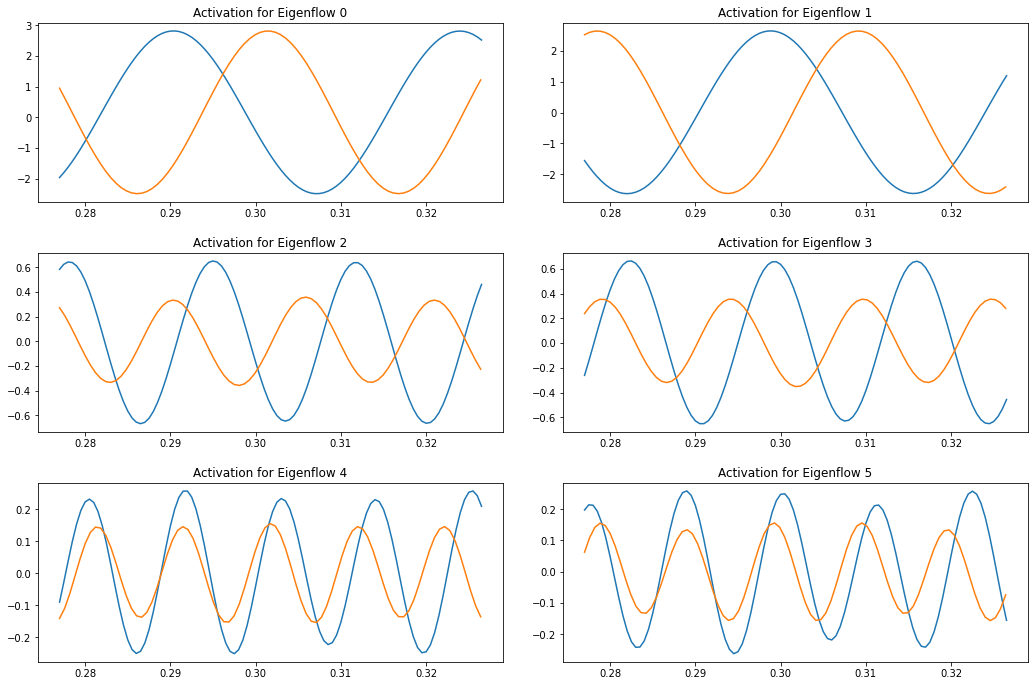

In [ ]:
# Galerkin model 
d = int(num/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span 
phase_shift = 94
plot_time_span = 100 * dt
orig_number = int(plot_time_span / (dt_ref )) #*1.09))
t_orig = np.linspace(sampling_span[-100],tmax-dt_ref,num=orig_number)

# add plots over full time domain
for i in range(num):
    if num <= 2:
        ax[int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t[-100:],sol.y[i,-100:]/(sos * mach))
        ax[int(i/2)][int(i%2)].plot(t_orig,coeffs[i,-(orig_number + phase_shift):-phase_shift]/(sos * mach))
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))

# Reconstruction

In [ ]:
# reconstruct flows
rec_len = 100
ssubsampling = int(shed_period / dt_ref / 20)
rec = np.repeat(np.expand_dims(q_avg,1),rec_len,1)
for i in range(num):
    rec += np.outer(pod_modes[:,i],sol.y[i,-100*ssubsampling::ssubsampling])

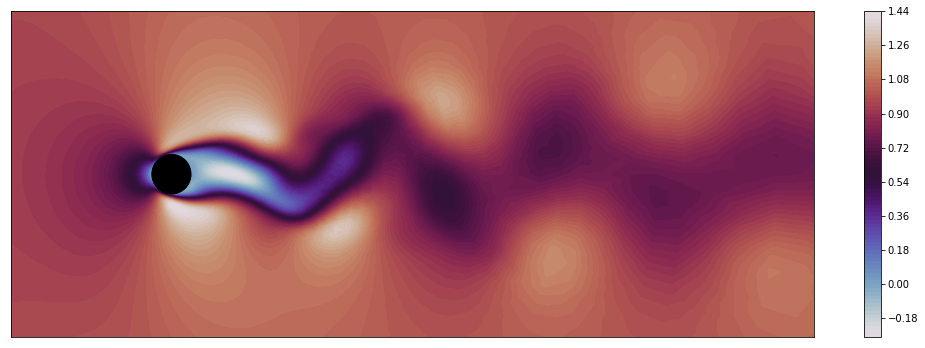

In [ ]:
for i in range(100):
    data = rec[0*n:1*n,i]/(sos * mach)
    data[0] = q[:n,0].max()/(sos * mach) * 1.8
    data[1] = q[:n,0].min()/(sos * mach)
    plot_cylinder_data(x,y,data,zoom=True,cmap='twilight')
    #fac = int(0.03 / (0.0001 * subsampling) / 20)
    #plot_cylinder_data(x,y,q[0*n:1*n,i*fac]/(sos * mach), zoom=True, cmap='twilight')
    #plt.savefig(str(i)+".png")
    #plt.close('all')
    break

# Optimal Control - Controlled System Dynamics

# Automatic Differentiation
- Parametrize Gamma -> $\beta_m$
- Declare $\beta_m$ as design variables
- Optimizationcycle for t -> $T_{Cal}$:
    1. Compute control input $\gamma(\beta)$
    2. Compute Galerkin activations $a(\gamma)$
    3. Compute cost function $J(a,\gamma)$
    4. Retrieve $\nabla_{\beta_m}J$ with AD
    5. Update $\beta_m$ with Gradient

# Optimal Control - Continuous Adjoint
- control trajectory $\gamma(\beta_m)$ 
- system trajectory $a(\gamma)$
- $\phi_k$ trajectory via costate problem
- gradient function $G( a_k,\gamma,\phi_k )$ -> analytical treatment
- Update $\beta_k$ with optimization step

In [ ]:
# Optimization Parameters
design_dim = 8                                                              # number of design parameters
design_vars = np.ones(design_dim)                                           # design variables for gamma

# Temporal Setup
t0 = 0                                                                      # starting time for optimization
tmax = shed_period * 20                                                      # end time for optimization -> 20 shedding periods
T = shed_period                                                             # shedding period
Nt = int(tmax/dt) + 1                                                       # floored number of timesteps
temporal_span = np.linspace(t0,tmax,num=int(tmax/dt)+1)                     # optimization time span

# initial conditions
a0 = coeffs[:num,0]                                                         # initial activations
gamma_start = 0                                                             # initial control
gamma_max = 10                                                              # maximum allowable control
phi0 = np.zeros(num) 

# criteria
epsilon = 1e-6                                                              # discontinuation criteria

In [ ]:
class controlOptimization:

    def __init__(self, designDim, timeInterval, dt, T, a0, phi0, control0, maxControl):
        
        self.designDim = designDim
        self.designVariables = -np.ones(designDim)

        # temporal setup
        self.t0 = timeInterval[0]
        self.tmax = timeInterval[1]
        self.dt = dt
        self.T = T
        self.Nt = int(tmax/dt) + 1

        # initial conditions
        self.a0 = a0
        self.phi0 = phi0
        self.control0 = control0

        # misc
        self.maxControl = maxControl
        self.N = 0.1 # control weight in cost 
        self.cost = 0

        # optimizaiton control
        self.epsilon = 1e-6
        self.alpha = 0.01
        self.maxIter = 100000

        # initialize arrays
        self.a = np.zeros((len(a0), Nt))
        self.phi = np.zeros((len(a0), Nt))
        self.gamma = np.zeros(Nt)
        self.grad = np.zeros(len(a0))


    # printing statements
    def status(self,print_string):
        print(f'{print_string:{"-"}<80}')

    # functions for single timestep output
    def control(self,t):
        tmp = self.control0 * (1 - t / self.T)
        for m in range(self.designDim):
            tmp += self.designVariables[m] * np.sin((m+1) * np.pi * t * 0.5 / self.T)
        return tmp

    def controlDerivative(self,t):
        tmp = - self.control0 * (1 / T)
        for m in range(self.designDim):
            tmp += self.designVariables[m] * np.cos((m+1) * np.pi * t * 0.5 / self.T) * m * np.pi * 0.5 / self.T
        return tmp

    def activation(self,t):
        if t % self.dt != 0:
            return 0.5 * (self.a[:,int(np.ceil(t/self.dt))] + self.a[:,int(np.floor(t/self.dt))])
        else:
            return self.a[:,int(t/self.dt)]     

    # RK45 ODE solver for forward/reverse time solve
    def solver(self,f,interval,y0,dt):
        # RK45 Solver -> trajectory of y
        t = interval[0]
        tmax = interval[1]
        Nt = np.abs(int((tmax-t)/dt)) + 1
        # reverse time alternative
        alt = False
        if (tmax < t):
            dt *= -1
            alt = True
        # initial condition
        y = np.zeros((y0.shape[0],Nt))
        y[:,0] = y0
        # stepping loop
        for i in range(Nt-1):
            k1 = dt * f(t,y[:,i])
            k2 = dt * f(t+dt/2,y[:,i]+k1/2)
            k3 = dt * f(t+dt/2,y[:,i]+k2/2)
            k4 = dt * f(t+dt,y[:,i]+k3)
            k = (k1+2*k2+2*k3+k4)/6
            y[:,i+1] = y[:,i] + k
            t = t + dt  
        if alt:
            return np.flip(y,1)
        else:
            return y
    
    # ODE system dynamics
    def costateProblem(self, t, phi):
        n = phi.shape[0]
        phi_dot = np.zeros(n)
        # time step activations
        a = self.activation(t)
        gamma = self.control(t)
        # looping dimensions
        for k in range(n):
            # costate linear vector
            A = np.zeros(n)
            # computing costate vector
            for i in range(n):
                tmp = 0
                for j in range(n):
                    tmp += (Q_[i][k,j] + Q_[i][j,k]) * a[j]
                A[i] = - (nu * L1[i][k] + L2[i][k] + tmp + g[i,k] * gamma)
            phi_dot[k] = np.inner(A,phi) - 0.5 * a[k]
        return phi_dot

    def galerkinSystem(self, t, a):
        n = a.shape[0]
        a_dot = np.zeros(n)
        gamma = self.control(t)
        dgamma = self.controlDerivative(t)
        # iterate dof
        for k in range(n):
            a_dot[k] = nu * b1[k] + b2[k] + np.inner((nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1)) + gamma * (nu * d1[k] + d2[k] + np.inner(g[k],a) + gamma * f[k]) + h[k] * dgamma
        # return activation derivative
        return a_dot

    def gradientFunction(self,phi):
        gradient = np.zeros(self.designDim)
        dim = phi.shape[0]
        # gradient computation loop
        for m in range(self.designDim):
            for n in range(self.Nt):    
                t = self.t0 + n * self.dt
                gamma = self.control(t)
                tmpTime = 0
                for k in range(dim):
                    # computing vector based A
                    A = np.zeros(dim)
                    for i in range(dim):
                        tmp = 0
                        for j in range(dim):
                            tmp += (Q_[i][j,k] + Q_[i][k,j]) * self.a[j,n]
                        A[i] = - (nu * L1[i][k] + L2[i][k] + tmp + g[i][k] * gamma)
                    tmp = 0
                    for i in range(dim):
                        tmp  += h[k] * A[i] * phi[i,n] + g[k][i] * self.a[i,n] * phi[k,n]
                    tmpTime += tmp + (nu * d1[k] + d2[k] + 2 * gamma * f[k]) * phi[k][n] - h[k] * 0.5 * self.a[k][n]
                gradient[m] += self.dt * (tmpTime  + np.exp(self.N * (np.power(gamma,2) - np.power(gamma_max,2))) * 2 * self.N * gamma) * np.sin((m+1) * np.pi * t * 0.5 / self.T)
        return gradient

    def costFunction(self):
        # cost function
        cost = 0
        dim = len(self.a0)
        for n in range(Nt - 1):
            t = self.t0 + n * self.dt
            cost += self.dt * (np.sum(np.square(self.a[:,n])) + np.exp(self.N * (np.power(self.control(t),2)-np.power(self.maxControl,2)))) 
            # lagrangian side constraints
            tmp_time = np.zeros(dim)
            for k in range(dim):
                tmp_time[k] = (self.a[k,n+1] - self.a[k,n]) / self.dt - nu * b1[k] - b2[k] - np.inner(nu*L1[k]+L2[k],self.a[:,n]) - np.inner(np.inner(self.a[:,n],Q_[k]),self.a[:,n]) - self.control(t) * (nu * d1[k] + d2[k]) - np.power(self.control(t),2) * f[k] - self.control(t) * np.inner(g[k],self.a[:,n]) - h[k] * self.controlDerivative(t)
            cost -= self.dt * np.inner(self.phi[:,n],tmp_time)   
        return cost

    def step(self):
        # construct control trajectory
        for n in range(Nt):
            self.gamma[n] = self.control(self.t0 + n * self.dt)
        # solving galerkin system
        self.a = self.solver(self.galerkinSystem,[self.t0,self.tmax],self.a0,self.dt)
        # solving costate ode dynamics in reverse time
        self.phi = self.solver(self.costateProblem,[self.tmax,self.t0],self.phi0,self.dt)
        # computing gradient step function
        self.grad = self.gradientFunction(self.phi)
        # perform update step
        self.designVariables -= self.alpha * self.grad
        # computing cost function
        self.cost = self.costFunction()

    def optimize(self):
        self.status("Optimization started with parameters ")
        self.status("Learning Rate: " + str(self.alpha))
        self.status("Iteration Limit: " + str(self.maxIter))
        # optimization loop
        for s in range(self.maxIter):
            # previouse cost
            prevCost = self.cost
            # computation step
            self.step()
            # step status
            sys.stdout.write("\r"f'{"Iteration: " + str(s):{""}<20}' + f'{"Cost: " + str(self.cost):{""}<60}')
            sys.stdout.flush()
            # discontinuation criterion
            if np.isnan(self.cost):
                self.status("Optimization failed and stopped! ")
                break
            if np.abs(prevCost - self.cost) < self.epsilon:
                self.status("")
                self.status("Optimization converged and finished! ")
                break

    def testGradFunction(self):
        # finite differences testing
        return 0


In [ ]:
optim = controlOptimization(20, [t0,tmax], dt,  T, a0, phi0, 0, 10)

In [ ]:
optim.optimize() 

Optimization started with parameters -------------------------------------------
Learning Rate: 0.01-------------------------------------------------------------
Iteration Limit: 100000---------------------------------------------------------


<ipython-input-19-385c0acb4e53>:149: RuntimeWarning: overflow encountered in exp
  cost += self.dt * (np.sum(np.square(self.a[:,n])) + np.exp(self.N * (np.power(self.control(t),2)-np.power(self.maxControl,2))))


Iteration: 0        Cost: inf                                                   

<ipython-input-19-385c0acb4e53>:140: RuntimeWarning: overflow encountered in exp
  gradient[m] += self.dt * (tmpTime  + np.exp(self.N * (np.power(gamma,2) - np.power(gamma_max,2))) * 2 * self.N * gamma) * np.sin((m+1) * np.pi * t * 0.5 / self.T)
<ipython-input-19-385c0acb4e53>:140: RuntimeWarning: invalid value encountered in double_scalars
  gradient[m] += self.dt * (tmpTime  + np.exp(self.N * (np.power(gamma,2) - np.power(gamma_max,2))) * 2 * self.N * gamma) * np.sin((m+1) * np.pi * t * 0.5 / self.T)
<ipython-input-19-385c0acb4e53>:45: RuntimeWarning: invalid value encountered in double_scalars
  tmp += self.designVariables[m] * np.sin((m+1) * np.pi * t * 0.5 / self.T)
<ipython-input-19-385c0acb4e53>:51: RuntimeWarning: invalid value encountered in double_scalars
  tmp += self.designVariables[m] * np.cos((m+1) * np.pi * t * 0.5 / self.T) * m * np.pi * 0.5 / self.T


Iteration: 1        Cost: nan                                                   Optimization failed and stopped! -----------------------------------------------


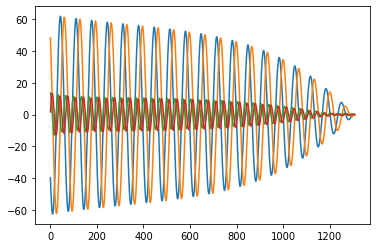

In [ ]:
for i in range(4):
    plt.plot(optim.phi[i,:])

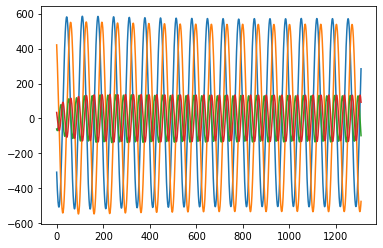

In [ ]:
for i in range(4):
    plt.plot(optim.a[i,:])

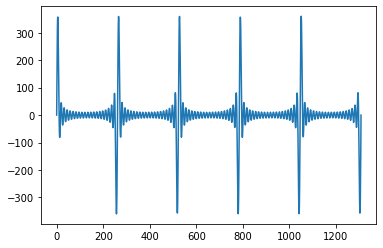

In [ ]:
plt.plot(optim.gamma[:])

In [ ]:
optim.designVariables

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf,  nan,  nan,  nan,  nan,  nan,  nan])